## Tensorflow: Classify images of clothing

https://www.tensorflow.org/tutorials/keras/classification

This is a clever example.

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.3.1


Now to import the data.

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [3]:
train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [4]:
class_names = ['Tshirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Let's take a look at one of the images

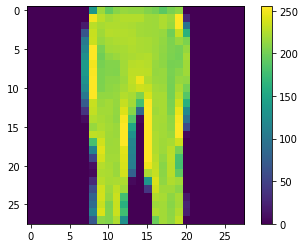

Trouser


In [5]:
plt.figure()
plt.imshow(train_images[54321])
plt.colorbar()
plt.grid(False)
plt.show()

print(class_names[train_labels[54321]])

Now we need to rescale the image data to (0,1).

In [6]:
train_images = train_images / 255.0
test_images = test_images / 255.0

Let's display 25 images to make sure we're good here.

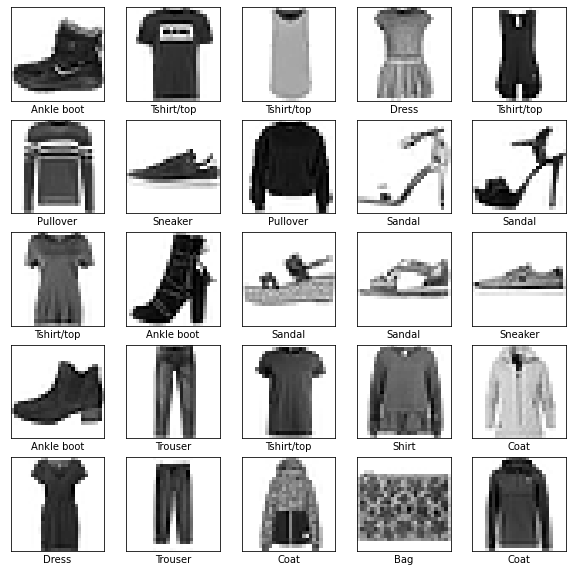

In [7]:
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

Looking good!  Let's work on a model.

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

Now we need to *compile* the model; this is where we add a loss function, an optimizer, and note which metrics we want to track.

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Now we fit the model.

In [10]:
model.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 1s 633us/step - loss: 0.4977 - accuracy: 0.8241
Epoch 2/10
1875/1875 [==============================] - 1s 608us/step - loss: 0.3717 - accuracy: 0.8663
Epoch 3/10
1875/1875 [==============================] - 1s 617us/step - loss: 0.3347 - accuracy: 0.8780
Epoch 4/10
1875/1875 [==============================] - 1s 579us/step - loss: 0.3102 - accuracy: 0.8857
Epoch 5/10
1875/1875 [==============================] - 1s 610us/step - loss: 0.2928 - accuracy: 0.8923
Epoch 6/10
1875/1875 [==============================] - 1s 577us/step - loss: 0.2772 - accuracy: 0.8978
Epoch 7/10
1875/1875 [==============================] - 1s 587us/step - loss: 0.2647 - accuracy: 0.9025
Epoch 8/10
1875/1875 [==============================] - 1s 582us/step - loss: 0.2545 - accuracy: 0.9044
Epoch 9/10
1875/1875 [==============================] - 1s 591us/step - loss: 0.2453 - accuracy: 0.9081
Epoch 10/10
1875/1875 [==============================] - 1s 629u

Up to 91% on the training set -- not bad!  But how does it do on the validation set?

In [11]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy: {}'.format(test_acc))

313/313 - 0s - loss: 0.3391 - accuracy: 0.8823

Test accuracy: 0.8823000192642212


Now we can use this model to make predictions.  The output we get from the model is/are *logits*: [the eector of raw (non-normalized) predictions made by a model](https://developers.google.com/machine-learning/glossary#logits).  In a multi-class classification problem, we typically take logits and pass them to the softmax function, which converts them to probabilities.  

In [12]:
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

predictions = probability_model.predict(test_images)

Let's look at the first prediction:

In [13]:
predictions[0]

array([9.9175608e-08, 3.5464600e-09, 1.6725888e-07, 4.0797401e-09,
       1.4903890e-07, 3.3057075e-02, 8.7300634e-07, 3.8230676e-02,
       2.5766965e-07, 9.2871076e-01], dtype=float32)

The highest value is the one the model is most confident in:

In [14]:
np.argmax(predictions[0]), class_names[np.argmax(predictions[0])]

(9, 'Ankle boot')

Is that right?

In [15]:
test_labels[0]

9

Now let's set up some ways to graph our predictions.

Our first helper function plots an image of the image that was used for prediction; it's labelled with the predicted label, the percent confidence, and color-coded to show correctness (blue) or wrongness (red).

In [16]:
def plot_image(i, predictions_array, true_labels, img):
    """Plot an image we made a prediction about, with some details about the prediction.
    
    Args:
    
    i: the index of the image we made a prediction of; used to index img.
    predictions_array: array of predictions for a particular image.
    true_labels:  the array of ground truth labels for the testing images
    img: all the images used for testing (ie, images we made predictions about).
    """
    # Because we're getting *all* the labels and images, use i 
    # to get the single label/image we're concerned about.
    true_label, img = true_labels[i], img[i]
    
    # Turn off distracting ticks & lines
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    # Show the image in black & white
    plt.imshow(img, cmap=plt.cm.binary)
    
    # Get the label with the most confident prediction
    predicted_label = np.argmax(predictions_array)
    # Color-code the label depending on correctness
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        
    # Create the x label
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
              color=color)

Next up, a helper function to plot the predictions that were made -- again, color-coded depending on correctness.

In [17]:
def plot_value_array(i, predictions_array, true_labels):
    """Plot the array of predictions made for a particular image:
    
    Args:
    i: index of the image we made a prediction for; used to index predictions_array and true_label.
    predictions_array: Array of predictions for a particular image.
    true_labels: the array of ground truth labels for the testing images
    """
    # Get the true label
    true_label = true_labels[i]
    
    # Set grids and ticks appropriately
    plt.grid(True)
    plt.xticks(range(10), class_names, rotation=90)
    # plt.xticks(class_names)
    # plt.yticks([])
    
    # Plot the predictions with a default color.
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    
    # Set the y limit appropriately
    plt.ylim([0, 1])
    
    # Get the predicted label
    predicted_label = np.argmax(predictions_array)
    
    # Set color appropriately
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Now let's look at some predictions!

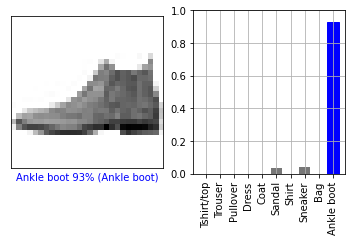

In [18]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)

How about another one?

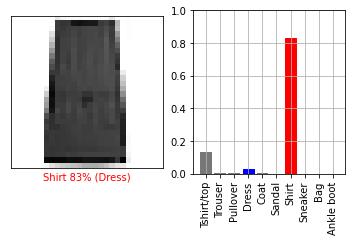

In [19]:
i = 42
plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1, 2, 2)
plot_value_array(i, predictions[i], test_labels)

Very wrong. 

Let's plot some more:

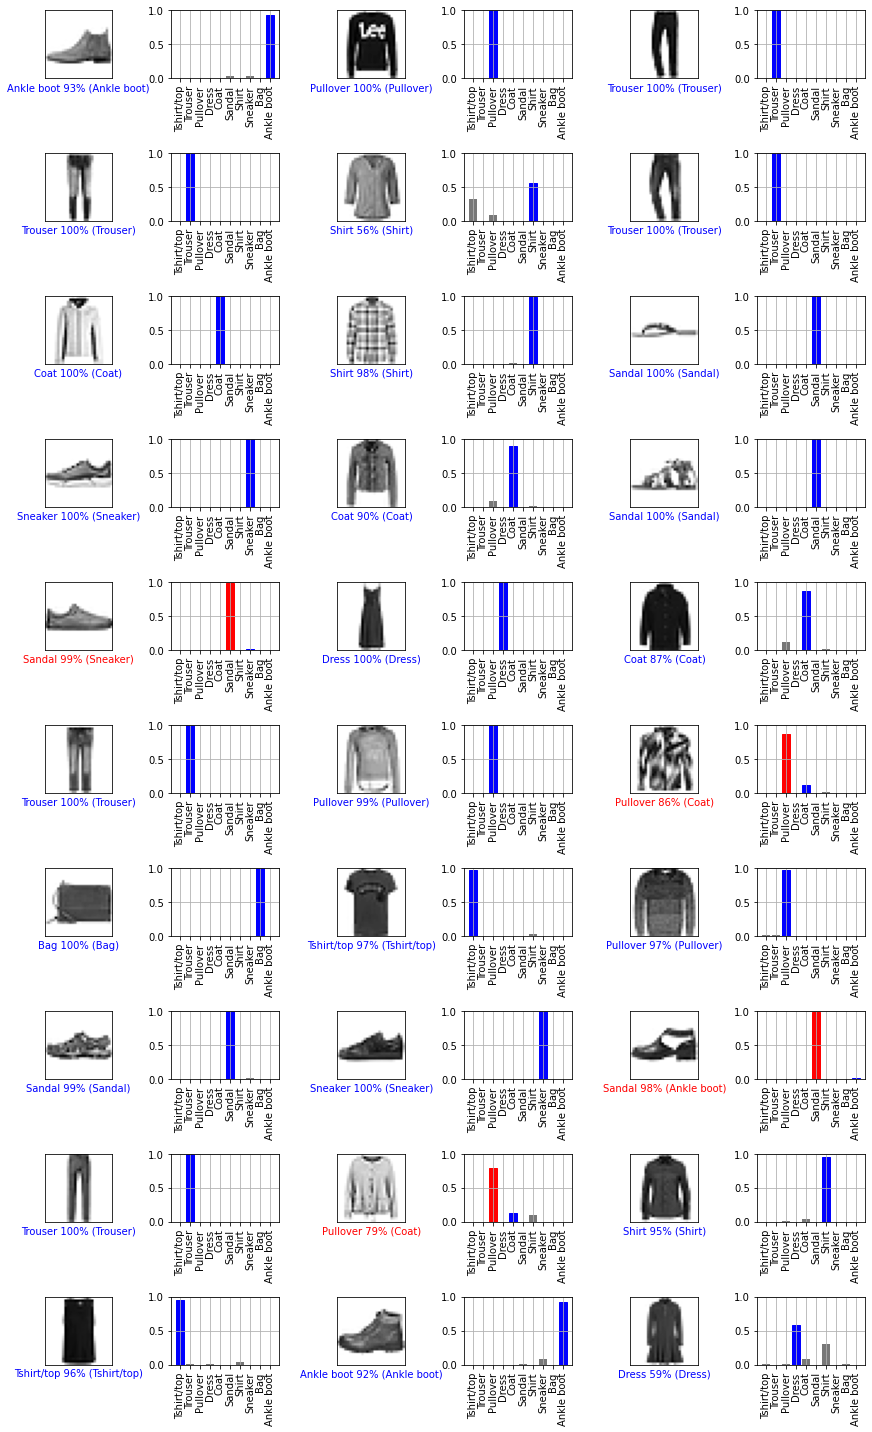

In [20]:
num_rows = 10
num_cols = 3
num_images = num_rows * num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions[i], test_labels, test_images)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Let's see if we can plot a confusion matrix.  Much help from [the matplotlib documentation](https://matplotlib.org/3.3.2/gallery/images_contours_and_fields/image_annotated_heatmap.html#sphx-glr-gallery-images-contours-and-fields-image-annotated-heatmap-py).

NameError: name 'my_confusion_matrix' is not defined

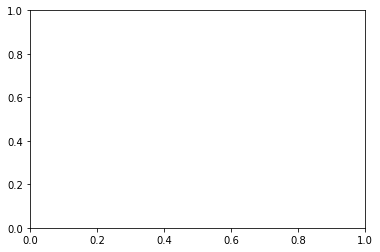

In [21]:
# Convenience
num_classes = len(class_names)

fig, ax = plt.subplots()
im = ax.imshow(my_confusion_matrix)

ax.set_xticks(range(num_classes))
ax.set_yticks(range(num_classes))

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Set the x labels to go on top
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

# Set the x labels to be rotated for clarity
plt.setp(ax.get_xticklabels(), rotation=-45, ha="right", rotation_mode="anchor")

plt.set_ylabel="True"
plt.set_xlabel="Predicted"

for i in range(num_classes):
    for j in range(num_classes):
        # Need to have `numpy()` here to turn it into a number
        text = ax.text(j, i, my_confusion_matrix[i, j].numpy(), ha="center", va="center", color="w")
        
ax.set_title("Confusion matrix.\nColumns=predictions, Rows=true")

So!  

- Shirts, tshirts, pullovers, dresses, and coats are hard to tell apart
- Ditto sneakers, ankle boots and sandles
- The colour scale could use adjusting, but this is not bad.



Now we'll make a prediction about a single image.  Note that `tf.keras` models work on batches -- so we need to make a list out of our single image.

In [22]:
img = test_images[1234]
print("Shape before: {}".format(img.shape))

# np.expand is like PyTorch's unsqueeze()
img = np.expand_dims(img, 0)
print("Shape after: {}".format(img.shape))

Shape before: (28, 28)
Shape after: (1, 28, 28)


In [23]:
predictions_single = probability_model.predict(img)
print(predictions_single)

[[1.0709636e-04 4.3541545e-06 3.1206989e-01 3.7846801e-06 6.6888434e-01
  1.0830319e-08 1.8928660e-02 1.9275549e-13 1.8580188e-06 5.4430771e-08]]


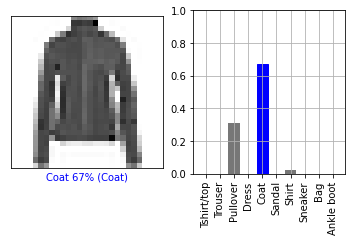

In [24]:
# Need to do this to match our earlier code...really calls for a refactoring.
labels_single = np.expand_dims(np.array(test_labels[1234]), 0)

plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plot_image(0, predictions_single, labels_single, img)
plt.subplot(1, 2, 2)
# Again: need to do this to match our earlier code...really calls for a refactoring.
plot_value_array(0, predictions_single[0], labels_single)

Okay: so can we convert this to work on a Coral dev board?

I'm going to start with post-training quantization, as [the documentation](https://www.tensorflow.org/model_optimization/guide/quantization/training) says its easier, and [the other documentation](https://coral.ai/docs/edgetpu/models-intro/#quantization) says quantization-aware training is still new in TF 2.

I'll be following along with the instructions in [this notebook](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb).

You need to re-train the data with a conversion dataset.  I'm going to take part of the original training dataset and hive it off for conversion.

In [25]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [26]:
train_images.shape

(60000, 28, 28)

In [27]:
splitting_point = 50000

conversion_images = train_images[splitting_point:]
conversion_labels = train_labels[splitting_point:]

train_images = train_images[:splitting_point]
train_labels = train_labels[:splitting_point]

train_images.shape, train_labels.shape, conversion_images.shape, conversion_labels.shape

((50000, 28, 28), (50000,), (10000, 28, 28), (10000,))

In [28]:
train_images = train_images / 255.0
conversion_images = conversion_images / 255.0
test_images = test_images / 255.0

# Explicitly cast these to float32, rather than the default float64
# See https://github.com/tensorflow/tensorflow/issues/34296 for details.

train_images = tf.dtypes.cast(train_images, tf.float32)
conversion_images = tf.dtypes.cast(conversion_images, tf.float32)
test_images = tf.dtypes.cast(test_images, tf.float32)

In [29]:
model_for_tpu = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10)
])

In [30]:
model_for_tpu.compile(optimizer='adam',
                      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                      metrics=['accuracy'])

model_for_tpu.fit(train_images, train_labels, epochs=10)

Epoch 1/10
1563/1563 [==============================] - 1s 633us/step - loss: 0.5116 - accuracy: 0.8205
Epoch 2/10
1563/1563 [==============================] - 1s 617us/step - loss: 0.3852 - accuracy: 0.8611
Epoch 3/10
1563/1563 [==============================] - 1s 626us/step - loss: 0.3446 - accuracy: 0.8738
Epoch 4/10
1563/1563 [==============================] - 1s 639us/step - loss: 0.3195 - accuracy: 0.8828
Epoch 5/10
1563/1563 [==============================] - 1s 617us/step - loss: 0.2981 - accuracy: 0.8896
Epoch 6/10
1563/1563 [==============================] - 1s 606us/step - loss: 0.2821 - accuracy: 0.8949
Epoch 7/10
1563/1563 [==============================] - 1s 650us/step - loss: 0.2712 - accuracy: 0.8998
Epoch 8/10
1563/1563 [==============================] - 1s 622us/step - loss: 0.2569 - accuracy: 0.9041
Epoch 9/10
1563/1563 [==============================] - 1s 680us/step - loss: 0.2495 - accuracy: 0.9072
Epoch 10/10
1563/1563 [==============================] - 1s 656u

In [31]:
test_loss, test_acc = model_for_tpu.evaluate(test_images, test_labels, verbose=2)
print("Test accuracy:", test_acc)

313/313 - 0s - loss: 0.3678 - accuracy: 0.8719
Test accuracy: 0.8719000220298767


Okay, model trained.  Now to convert!

In [32]:
# Zeroth: create a TF Dataset for our conversion images
def conversion_data_gen():
    conversion_dataset = tf.data.Dataset.from_tensor_slices(conversion_images)
    dataset_size = len(conversion_images)
    for i in range(dataset_size):
        image = next(iter(conversion_dataset))
        yield [image]

# First, create a converter...
converter = tf.lite.TFLiteConverter.from_keras_model(model)


# Enable quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Set the representative dataset
converter.representative_dataset = conversion_data_gen

# This ensures that if any ops can't be quantized, we'll throw an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

# For full integer quantization; though supported types defaults to int8 only, we'll explicitly declare it.
converter.target_spec.supported_types = [tf.int8]

# Set input & output tensors to uint8 (added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Now convert
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpuvmd0x0g/assets


# Problems I ran into:

## Conversion wants a generator, not a dataset

The notebook is right when it insists on wrapping the dataset in a yield.  I'm not entirely sure what's going on there.


## `Cannot set tensor` when converting `flatten_input`

Full backtrace:
```
ValueError: Cannot set tensor: Got value of type NOTYPE but expected type FLOAT32 for input 0, name: flatten_input 
```

At first, I looked at [this StackExchange answer](https://stackoverflow.com/questions/62580548/is-the-keras-function-flatten-supported-by-tensorflow-lite); however, it didn't seem relevant.  Next I found 
 [this Github issue](https://github.com/tensorflow/tensorflow/issues/34296), which explained the error in terms of hidden data types:
 
 > Conversion is successful if the data type is float32. If the data type of input data is float64, then it will throw ValueError: Cannot set tensor: Got value of type NOTYPE but expected type FLOAT32 for input 0, name: flatten_input which is not clear. Most of the keras models In Tensorflow website under tutorials are with float64 datatype. So, if the user try to convert them into tf_lite model, they will end up in this ValueError. I think we need to update the Error description. Instead of showing NOTYPE, may it is better to use float64 or other data types that are not compatible.
 
Looking at `train_images.dtype` showed that they were, in fact, float64.

The response in that ticket:

> float64 isn't supported in the TFLite interpreter. The supported types are available here.
> Because it's not trivial to change the error message that is shown here without adding support for float64, I am closing this issue.

Adding this bit of code did the trick:

```
# Explicitly cast these to float32, rather than the default float64
# See https://github.com/tensorflow/tensorflow/issues/34296 for details.

train_images = tf.dtypes.cast(train_images, tf.float32)
conversion_images = tf.dtypes.cast(conversion_images, tf.float32)
test_images = tf.dtypes.cast(test_images, tf.float32)
```

And after that, I was able to convert!

Now time to write it out.

In [ ]:
with open('fashion_mnist_v0.0.1_quant.tflite', 'wb') as f:
    f.write(tflite_model)

Let's compare the accuracy.

In [33]:
def set_input_tensor(interpreter, input):
    input_details = interpreter.get_input_details()[0]
    tensor_index = input_details['index']
    input_tensor = interpreter.tensor(tensor_index)()[0]
    # Inputs for the TFLite model must be uint8, so we quantize our input data.
    scale, zero_point = input_details['quantization']
    input_tensor[:, :] = np.uint8(input / scale + zero_point)
    
def classify_image(interpreter, input):
    set_input_tensor(interpreter, input)
    interpreter.invoke()
    output_details = interpreter.get_output_details()[0]
    output = interpreter.get_tensor(output_details['index'])
    # Outlputs from the TFLite model are unit8, so we have to dequantize the results
    scale, zero_point = output_details['quantization']
    output = scale * (output - zero_point)
    top_1 = np.argmax(output)
    return top_1

interpreter = tf.lite.Interpreter('fashion_mnist_v0.0.1_quant.tflite')
interpreter.allocate_tensors()

batch_prediction = []
for i in range(len(test_images)):
    prediction = classify_image(interpreter, test_images[i])
    batch_prediction.append(prediction)
    
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, test_labels)
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()*100))

Quant TF Lite accuracy: 76.000%


Note:  [tf.keras.metrics.Accuracy()](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Accuracy) returns in the range 0-1, not 0-100.  Originally I thought my accuracy was 0.76%...

How does this compare with the original model?

In [34]:
test_loss, test_acc = model_for_tpu.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy: {}'.format(test_acc))

313/313 - 0s - loss: 0.3678 - accuracy: 0.8719

Test accuracy: 0.8719000220298767


Hm -- I'm going to assume that's in line with what [the original notebook](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb#scrollTo=srOYhMYfx9XH) calls "not very much accuracy drop".

Gahh...the edgetpu compiler is only available on Debian systems, and only on x86_64 architecture. (╯°□°)╯︵ ┻━┻

Doing this on my home machine.

In [ ]:
!ls -l

# TODO

- Try running this on coral board
- Try putting flask in front of this
- Try putting a decent HTML UI in front of the API

In [37]:
# Write out labels file
labels = '\n'.join(class_names)
with open('fashion_mnist_labels.txt', 'w') as f:
    f.write(labels)

In [38]:
!ls -l

total 696
-rw-rw-r-- 1 aardvark aardvark     74 Nov 12 10:03 fashion_mnist_labels.txt
-rw-rw-r-- 1 aardvark aardvark 148000 Nov 11 13:59 fashion_mnist_v0.0.1_quant_edgetpu.tflite
-rw-rw-r-- 1 aardvark aardvark 104480 Nov 11 13:59 fashion_mnist_v0.0.1_quant.tflite
-rw-rw-r-- 1 aardvark aardvark 443702 Nov 12 09:59 mnist_fashion.ipynb
-rw-r--r-- 1 aardvark aardvark    412 Nov 12 09:50 sample.png


# Current status

- Copied model file to c2
- Tried downloading random picture of tshirt & classifying; got this error:

```
python3 ./classify_image.py --model ~/fashion_mnist_v0.0.1_quant_edgetpu.tflite --labels ~/fashion_mnist_labels.txt  --input /tmp/tshirt.jpg 
Traceback (most recent call last):
  File "./classify_image.py", line 122, in <module>
    main()
  File "./classify_image.py", line 102, in main
    size = classify.input_size(interpreter)
  File "/home/mendel/coral/tflite/python/examples/classification/classify.py", line 31, in input_size
    _, height, width, _ = input_details(interpreter, 'shape')
ValueError: not enough values to unpack (expected 4, got 3)
```

- Tried [this technique](https://stackoverflow.com/questions/35842274/convert-own-image-to-mnists-image) to convert that image to mnist-like png; got same error

- Invoking another classifier worked:

```
$ python3 ./classify_image.py --model ~/mobilenet_v2_1.0_224_quant_edgetpu.tflite --labels ~/fashion_mnist_labe\
ls.txt  --input /tmp/tshirt.jpg 
----INFERENCE TIME----
Note: The first inference on Edge TPU is slow because it includes loading the model into Edge TPU memory.
11.5ms
2.6ms
2.4ms
2.3ms
2.8ms
-------RESULTS--------
Dress: 0.94141
```

- Labels are all wrong for that; model came from [this notebook](https://colab.research.google.com/github/google-coral/tutorials/blob/master/retrain_classification_ptq_tf2.ipynb#scrollTo=RwywT4ZpQjLf).

In [36]:
!ls -l

total 692
-rw-rw-r-- 1 aardvark aardvark 148000 Nov 11 13:59 fashion_mnist_v0.0.1_quant_edgetpu.tflite
-rw-rw-r-- 1 aardvark aardvark 104480 Nov 11 13:59 fashion_mnist_v0.0.1_quant.tflite
-rw-rw-r-- 1 aardvark aardvark 443225 Nov 12 09:57 mnist_fashion.ipynb
-rw-r--r-- 1 aardvark aardvark    412 Nov 12 09:50 sample.png
